In [1]:
from keras.layers import Lambda,Input,Dense,Flatten,Conv2D,Reshape,Conv2DTranspose
from keras.models import Model
from keras.datasets import fashion_mnist,mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
def sampling(arg):
    arg = [z_mean,z_log_var]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], dim),mean=0.0, stddev=1.0) # reparameterization trick
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
# test dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train,-1)
X_test =  np.expand_dims(X_test,-1)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [4]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [5]:
# network parameters
channel = 1
rows = X_train.shape[1]
cols = X_train.shape[2]
input_shape = (rows,cols,channel)
batch_size = 128
latent_dim = 2
epochs = 10

In [6]:
# build encoder model
inputs = Input(shape=input_shape)

x = Conv2D(32,3,activation='relu',strides=2,padding='same')(inputs)
x = Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
before_flatten_shape = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean,z_log_var,z])
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [7]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(before_flatten_shape[1]*before_flatten_shape[2]*before_flatten_shape[3], activation='relu')(latent_inputs)
x = Reshape((before_flatten_shape[1],before_flatten_shape[2],before_flatten_shape[3]))(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
outputs = Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_________________________________________________________________


In [8]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

In [11]:
# reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= rows * cols

kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [12]:
# vae.load_weights('vae_mnist.h5') # load all the weights for encoder and decoder when loading for vae

In [13]:
X_train.shape

(60000, 28, 28, 1)

In [14]:
X_test.shape

(10000, 28, 28, 1)

In [15]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

hist = vae.fit(X_train,epochs=50,batch_size=batch_size,validation_data=(X_test, None))
# vae.save_weights('vae_fashion_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 140us/step - loss: 314.0703 - val_loss: 290.2721
Epoch 2/50
60000/60000 [==============================] - 6s 96us/step - loss: 283.3741 - val_loss: 280.0318
Epoch 3/50
60000/60000 [==============================] - 6s 96us/step - loss: 277.3257 - val_loss: 277.0235
Epoch 4/50
60000/60000

In [16]:
def training_plot(hist,model_name):
    loss = [hist.history['loss'],hist.history['val_loss']]
#     acc = [hist.history['acc'],hist.history['val_acc']]
    plt.plot(loss[0],color='b',label='training')
    plt.plot(loss[1],color='r',label='valid')
#     fig, axes = plt.subplots(1,2,figsize = (15,3))
#     fig.suptitle(model_name)
#     for ax,val,name in zip(axes,(loss,acc),['loss','accuracy']):
#         ax.plot(val[0], color='b', label="Training")
#         ax.plot(val[1], color='r', label="Validation")
#         ax.legend(loc='best')
#         ax.set_xlabel('epoch')
#         ax.set_ylabel('')
#         ax.set_title(name)

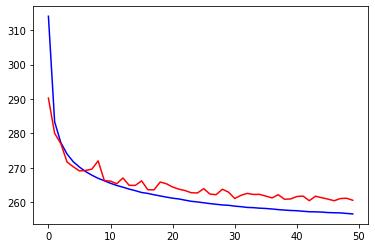

In [17]:
training_plot(hist,'vae')

[[0.17289373 1.1179647 ]]
[[-1.8924555  0.7380992]]


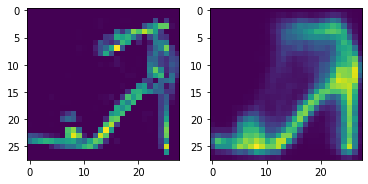

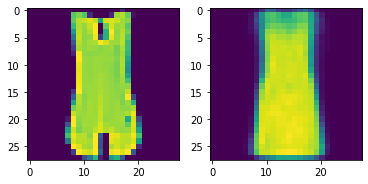

In [18]:
original_1 = X_train[8]
encoded_z_1 = encoder.predict(np.expand_dims(original_1,0),batch_size=1)[2]
print(encoded_z_1)
predict = decoder.predict(encoded_z_1)
original_digit_1 = original_1.reshape(rows,cols)
decoded_digit_1 = predict.reshape(rows,cols)
fig, axes = plt.subplots(1,2)
axes[0].imshow(original_digit_1)
axes[1].imshow(decoded_digit_1)

original_2 = X_train[4]
encoded_z_2 = encoder.predict(np.expand_dims(original_2,0),batch_size=1)[2]
print(encoded_z_2)
predict = decoder.predict(encoded_z_2)
original_digit_2 = original_2.reshape(rows,cols)
decoded_digit_2 = predict.reshape(rows,cols)
fig, axes = plt.subplots(1,2)
axes[0].imshow(original_digit_2)
axes[1].imshow(decoded_digit_2)

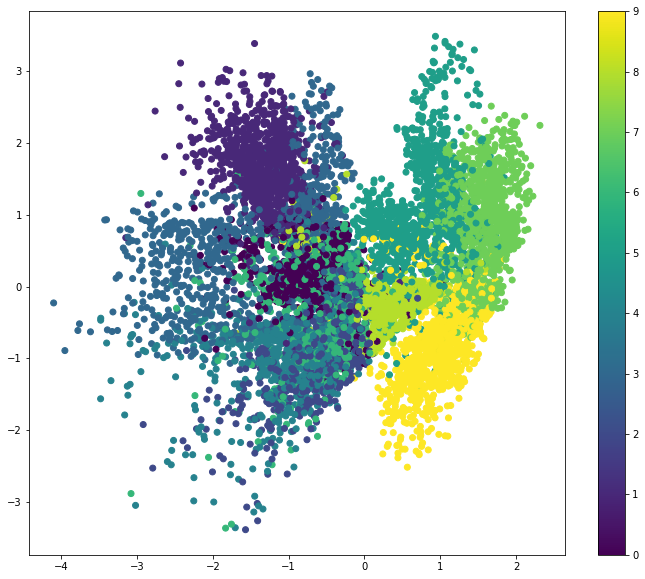

In [19]:
X_test_encoded = encoder.predict(X_test, batch_size=1)[2]

plt.figure(figsize=(12, 10))
plt.scatter(X_test_encoded[:,0], X_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

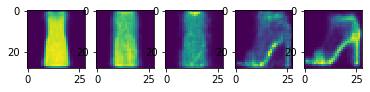

In [21]:
center_z = (encoded_z_1+encoded_z_2)/2
toward_1_z = (encoded_z_1+center_z)/2
toward_1_1_z = (encoded_z_1+toward_1_z)/2
# print(center_z)
# print(toward_1_z)
predict_center = decoder.predict(center_z)
predict_toward_1 = decoder.predict(toward_1_z)
predict_toward_1_1 = decoder.predict(toward_1_1_z)

decoded_digit_new_center = predict_center.reshape(rows,cols)
decoded_digit_new_toward_1 = predict_toward_1.reshape(rows,cols)
decoded_digit_new_toward_1_1 = predict_toward_1_1.reshape(rows,cols)

fig, axes = plt.subplots(1,5)
axes[0].imshow(decoded_digit_2)
axes[1].imshow(decoded_digit_new_center)
axes[2].imshow(decoded_digit_new_toward_1)
axes[3].imshow(decoded_digit_new_toward_1_1)
axes[4].imshow(decoded_digit_1)


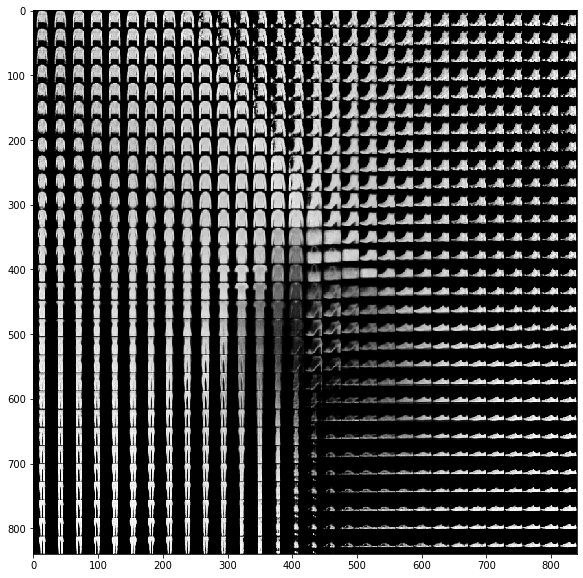

In [22]:
# display a 2D manifold of the digits
n = 30  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show()